In [ ]:
import numpy as np 
import pandas as pd 
import re
import cv2
import json
import pytesseract
import numpy as np
import pandas as pd
import PIL
from PIL import Image, ImageDraw
from pytesseract import Output
import matplotlib.pyplot as plt

import os

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe' # Change your Tesseract directory here PWEASE <3

In [2]:
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [3]:
MAIN_FILE_PATH = 'C:/Users/User/Downloads' # Change your directory here as well to where your output jsonl file from Doccano is located <3

In [4]:
def crop_image(row):
    """Crop image based on coordinates.
    """
    
    file_name = row['filename']
    image = cv2.imread(f'{MAIN_FILE_PATH}/{file_name}')
    
    x1 = round(row['x1'])
    y1 = round(row['y1'])
    x2 = round(row['x2'])
    y2 = round(row['y2'])
    
    cropped_image = image[y1:y2, x1:x2]
    
    return cropped_image

In [5]:
custom_config = '--oem 3 --psm 6 -c preserve_interword_spaces=1'

def get_image_text(image, config=custom_config):
    """OCR image to get text from it.

    Args:
        image (_type_): input image of a document
        config (str, optional): Settings for tesseract OCR. Defaults to custom_config.

    Returns:
        str: Extracted text from image
    """
    # Convert to gray scale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # threshold_img = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    ocr_output = pytesseract.image_to_string(gray_image, lang='eng', config=config)
    
    return ocr_output

In [6]:
def get_info_by_id(df: pd.DataFrame, id: int) -> pd.DataFrame:
    """Return data from table by id.

    Args:
        df (pd.DataFrame): input dataframe
        id (int): object linked id in the dataframe

    Returns:
        pd.DataFrame: DataFrame slice
    """
    df_new = df[df['id'] == id]
    
    return df_new

In [7]:
def tryloc(df, col_input, col_output, value, default=None) -> str:
  """Return text from one column based on another column value.
  If there is any issue with col_output, return default value.

  Args:
      df (pd.DataFrame): input dataframe
      col_input (str): column whose values to check
      col_output (str): column whose values to take based on col_input condition
      value (str): value to look for in col_input
      default (str, optional): if any problem with col_output return dafault. Defaults to None.

  Returns:
      str: output from condition
  """
  
  try:
    return df.loc[df[col_input]==value, col_output].iloc[0]
  except IndexError:
    return default

In [75]:
def add_to_dict(df: pd.DataFrame) -> dict:
    """Format dataframe data into dict.

    Args:
        df (pd.DataFrame): Dataframe containing extracted OCR data.

    Returns:
        dict: Formatted dictionary with structured data.
    """
    dct = dict()

    dct['merchant'] = tryloc(df, 'label', 'text', 'merchant') or None
    dct['date'] = tryloc(df, 'label', 'text', 'date') or None
    dct['recipient'] = tryloc(df, 'label', 'text', 'recipient') or None

    dct = {k: v for k, v in dct.items() if v is not None}

     # dct['menu'] = {
    #     'nm': tryloc(df, 'label', 'text', 'item'),
    #     'num': tryloc(df, 'label', 'text', 'num'),
    #     'unitprice': tryloc(df, 'label', 'text', 'unitprice'),
    #     'cnt': tryloc(df, 'label', 'text', 'cnt'),
    #     'discountprice': tryloc(df, 'label', 'text', 'discountprice'),
    #     'price': tryloc(df, 'label', 'text', 'price'),
    #     'itemsubtotal': tryloc(df, 'label', 'text', 'itemsubtotal'),
    #     'etc': tryloc(df, 'label', 'text', 'etc'),
    # }
    
    menu_items = []
    current_item = {}

    # df = df.sort_values(by='y1')
    # print(df)

    # for _, row in df.iterrows():
    #     if row['label'] == 'nm':
    #         # If there's an existing item, push it to the list before starting a new one
    #         if current_item.get('nm'):
    #             # Remove None values from the current item before saving
    #             menu_items.append({k: v for k, v in current_item.items() if v is not None})
    #             current_item = {}

    #         # Start a new menu item — inherit existing attributes if they exist
    #         current_item['nm'] = row['text']
    #         current_item.setdefault('num', None)
    #         current_item.setdefault('unitprice', None)
    #         current_item.setdefault('lineprice', None)
    #         current_item.setdefault('discountprice', None)
    #         current_item.setdefault('price', None)
    #         current_item.setdefault('itemsubtotal', None)
    #         current_item.setdefault('etc', None)

    #     elif row['label'] == 'cnt':
    #         # Set value even if item hasn't appeared yet
    #         current_item.setdefault('cnt', row['text'])

    #     elif row['label'] == 'unitprice':
    #         # Set value even if item hasn't appeared yet
    #         current_item.setdefault('unitprice', row['text'])

    #     elif row['label'] == 'num':
    #         # Set value even if item hasn't appeared yet
    #         current_item.setdefault('num', row['text'])

    #     elif row['label'] == 'discountprice':
    #         # Set value even if item hasn't appeared yet
    #         current_item.setdefault('discountprice', row['text'])

    #     elif row['label'] == 'price':
    #         # Set value even if item hasn't appeared yet
    #         current_item.setdefault('price', row['text'])

    #     elif row['label'] == 'itemsubtotal':
    #         # Set value even if item hasn't appeared yet
    #         current_item.setdefault('itemsubtotal', row['text'])

    #     elif row['label'] == 'etc':
    #         # Set value even if item hasn't appeared yet
    #         current_item.setdefault('etc', row['text'])

        #print(current_item)

    
    # if current_item:
    #     menu_items.append({k: v for k, v in current_item.items() if v is not None})

    # if menu_items:
    #     dct['menu'] = menu_items

    
    nm_list = df.loc[df['label'] == 'nm', ['text', 'y1']].sort_values(by='y1').to_dict('records')
    cnt_list = df.loc[df['label'] == 'cnt', ['text', 'y1']].sort_values(by='y1').to_dict('records')
    num_list = df.loc[df['label'] == 'num', ['text', 'y1']].sort_values(by='y1').to_dict('records')
    unitprice_list = df.loc[df['label'] == 'unitprice', ['text', 'y1']].sort_values(by='y1').to_dict('records')
    lineprice_list = df.loc[df['label'] == 'lineprice', ['text', 'y1']].sort_values(by='y1').to_dict('records')
    discountprice_list = df.loc[df['label'] == 'discountprice', ['text', 'y1']].sort_values(by='y1').to_dict('records')
    price_list = df.loc[df['label'] == 'price', ['text', 'y1']].sort_values(by='y1').to_dict('records')
    itemsubtotal_list = df.loc[df['label'] == 'itemsubtotal', ['text', 'y1']].sort_values(by='y1').to_dict('records')
    etc_list = df.loc[df['label'] == 'etc', ['text', 'y1']].sort_values(by='y1').to_dict('records')
    
    menu_items = []
    
    while nm_list or num_list or unitprice_list or lineprice_list or discountprice_list or price_list or itemsubtotal_list or etc_list:
        item = {}

        # Pop from each list (if available)
        if nm_list:
            item['nm'] = nm_list.pop(0)['text']
        if cnt_list:
            item['cnt'] = cnt_list.pop(0)['text']
        if num_list:
            item['num'] = num_list.pop(0)['text']
        if unitprice_list:
            item['unitprice'] = unitprice_list.pop(0)['text']
        if lineprice_list:
            item['lineprice'] = lineprice_list.pop(0)['text']
        if discountprice_list:
            item['discountprice'] = discountprice_list.pop(0)['text']
        if price_list:
            item['price'] = price_list.pop(0)['text']
        if itemsubtotal_list:
            item['itemsubtotal'] = itemsubtotal_list.pop(0)['text']
        if etc_list:
            item['etc'] = etc_list.pop(0)['text']

        # Remove None values and store the item
        if item:
            item = {k: v for k, v in item.items() if v is not None}
            menu_items.append(item)
    if menu_items:
        dct['menu'] = menu_items


    subtotal = {
        'subtotal_price': tryloc(df, 'label', 'text', 'subtotal_price'),
        'discount_price': tryloc(df, 'label', 'text', 'discount_price'),
        'service_price': tryloc(df, 'label', 'text', 'service_price'),
        'othersvc_price': tryloc(df, 'label', 'text', 'othersvc_price'),
        'tax_price': tryloc(df, 'label', 'text', 'tax_price'),
        'etc': tryloc(df, 'label', 'text', 'subtotal_etc')
    }

    subtotal = {k: v for k, v in subtotal.items() if v is not None}
    
    if subtotal:
        dct['subtotal'] = subtotal

    total = {
        'total_price': tryloc(df, 'label', 'text', 'total_price'),
        'total_etc': tryloc(df, 'label', 'text', 'total_etc'),
        'cashprice': tryloc(df, 'label', 'text', 'cashprice'),
        'changeprice': tryloc(df, 'label', 'text', 'changeprice'),
        'menuqty_cnt': tryloc(df, 'label', 'text', 'menuqty_cnt')
    }

    total = {k: v for k, v in total.items() if v is not None}

    if total:
        dct['total'] = total

    return dct


In [76]:
# Change your directory here: This is the file that looks up the jsonl output from Doccano
# f = open('C:/Users/User/Downloads/all.jsonl')
with open('C:/Users/User/Downloads/all3.jsonl', 'r') as f:
    data = [json.loads(line) for line in f]

# Now you have a list of dictionaries, one for each line in the JSONL file
# print(data)
# image_tags = json.load(f)

In [77]:
dataset_donut = []

In [78]:
for image_tags in data:
    flatten = pd.json_normalize(image_tags, meta=["id", "filename"], record_path=["bbox"])
    flatten.rename(columns={"x": "x1", "y": "y1"}, inplace=True)
    flatten['x2'] = flatten['x1'] + flatten['width']
    flatten['y2'] = flatten['y1'] + flatten['height']
    final_coordinates = flatten[['id', 'filename', 'x1', 'y1', 'x2', 'y2', 'width', 'height', 'label']]
    final_coordinates['text'] = final_coordinates.apply(lambda row: get_image_text(crop_image(row)), axis=1)
    # Edit output text to remove newline string, double quotes and extra whitespace
    # ---- before json-ing the text
    final_coordinates['text'] = final_coordinates['text'].apply(lambda row: row.strip())
    final_coordinates['text'] = final_coordinates['text'].apply(lambda row: row.replace('\n', " "))
    final_coordinates['text'] = final_coordinates['text'].apply(lambda row: row.replace('"', " "))
    final_coordinates['text'] = final_coordinates['text'].apply(lambda row: re.sub(' +', ' ', row))

    #print(final_coordinates)

    ids_list = final_coordinates['id'].unique()

    for id in ids_list:
        df_segment = get_info_by_id(final_coordinates, id)
        dataset_donut.append({
                'id': id,
                'file_name': final_coordinates.loc[final_coordinates['id']==id, 'filename'].iloc[0],
                'ground_truth': {
                        'gt_parse': add_to_dict(df_segment)
            }})    

In [79]:
dataset_donut

[{'id': 6,
  'file_name': 'testing.png',
  'ground_truth': {'gt_parse': {'menu': [{'nm': 'RLUS WAITS',
      'cnt': 'as',
      'num': 'OS71-1a54',
      'unitprice': '120,00)',
      'itemsubtotal': '120,000'},
     {'nm': 'eras',
      'cnt': '1',
      'num': '1002-g050',
      'unitprice': 'Ren',
      'itemsubtotal': '0'}],
    'total': {'total_price': '120,000', 'changeprice': '6'}}}},
 {'id': 7,
  'file_name': 'MY-2.jpg',
  'ground_truth': {'gt_parse': {'merchant': 'PakCik Wong',
    'date': '23Sep 200',
    'menu': [{'nm': 'italian Coffee', 'cnt': '\\', 'itemsubtotal': '(480'},
     {'nm': 'Honey Dew', 'cnt': 'i |', 'itemsubtotal': '6.80'},
     {'nm': 'Oranges', 'cnt': '\\', 'itemsubtotal': '6.8V'},
     {'nm': 'passion Fruit Téa', 'cnt': 'i', 'itemsubtotal': '480'},
     {'nm': 'Watan Hot', 'cnt': '\\', 'itemsubtotal': '8.80'},
     {'nm': 'Sotong (KunagPoh)', 'cnt': '\\', 'itemsubtotal': 'a BO'},
     {'nm': 'Fish Fillet (Salted Egg) —', 'cnt': '1', 'itemsubtotal': 'B.BV'},


In [23]:
# Extract in jsonl format

# with open('/kaggle/working/tesseract-ocred.jsonl', 'w', encoding='utf8') as outfile:
#     for entry in dataset_donut:
#         json.dump(entry, outfile, ensure_ascii=False)
#         outfile.write('\n')

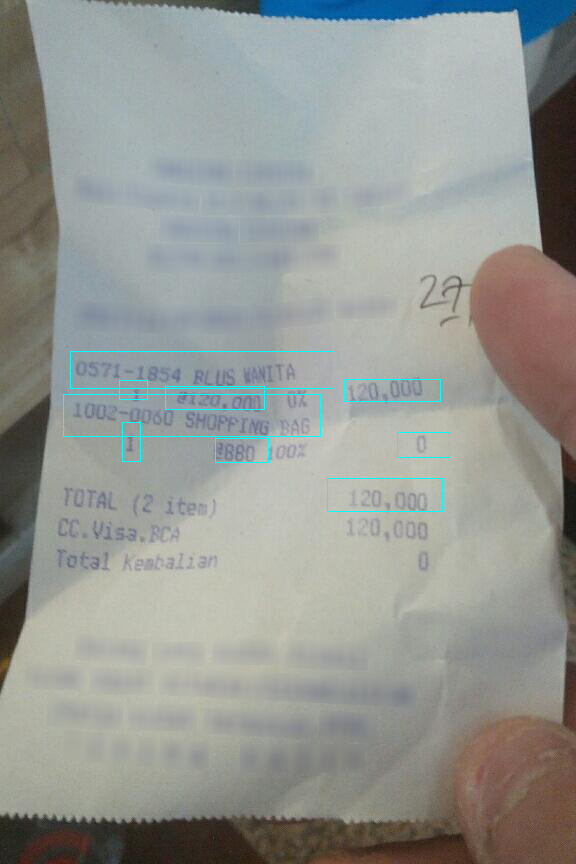

In [35]:
# source_img = Image.open('C:/Users/User/Downloads/testing.png').convert("RGBA")

# draw = ImageDraw.Draw(source_img)
# for ind, row in final_coordinates.iterrows():
#     draw.rectangle(((row['x1'], row['y1']), (row['x2'], row['y2'])), outline='cyan')

# source_img